In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
from scipy.stats import mstats
%matplotlib inline

In [3]:
plt.style.use("ggplot")

In [4]:
df = pd.read_excel("./data/dose_response.xlsx")

In [5]:
df.head()

,log10 C,death
0,0.95,0
1,0.94,0
2,0.95,0
3,0.96,0
4,0.99,0


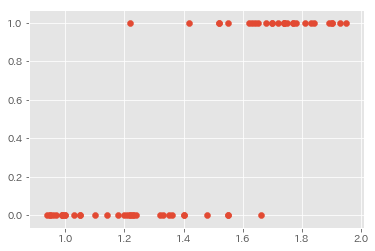

In [6]:
plt.scatter(df["log10 C"], df["death"])

In [9]:
stan_model = """
data {
    int N;
    real X[N];
    int<lower=0, upper=1> Y[N];
}
parameters {
    real a;
    real b;
}
model {
    for (n in 1:N){
        Y[n] ~ bernoulli_logit(a * X[n] + b);
    }
}
"""

In [10]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2c3da65694b518f8553fce4fca97e462 NOW.
C:\Users\s.takai\Anaconda3\envs\tf\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\SF871~1.TAK\AppData\Local\Temp\tmps7tpl_bi\stanfit4anon_model_2c3da65694b518f8553fce4fca97e462_2765702249870610187.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [11]:
stan_data = {"N": df.shape[0], "X": df["log10 C"], "Y": df["death"]}

In [12]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=3, seed=123)

In [13]:
fit

Inference for Stan model: anon_model_2c3da65694b518f8553fce4fca97e462.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     13.73    0.16   3.53   7.81  11.24  13.38  15.77  21.87    492    1.0
b     -20.5    0.24   5.36 -32.98 -23.68 -20.02 -16.73  -11.6    493    1.0
lp__ -14.97    0.04   1.06 -17.78 -15.41 -14.64 -14.19 -13.89    773    1.0

Samples were drawn using NUTS at Sat Feb 23 22:24:37 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [14]:
a, b = 13.73, -20.5

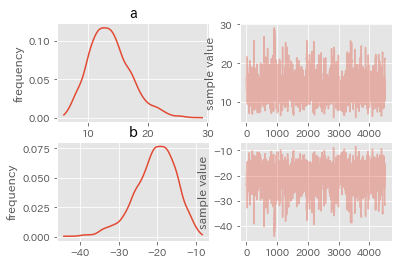

In [15]:
fig = fit.plot()

In [16]:
ms_a = fit.extract("a")["a"]
ms_b = fit.extract("b")["b"]

In [17]:
x = np.arange(1.0, 2.0, 0.01)
f = lambda x : 1.0 / (1.0 + np.exp(-x))
df_b = pd.DataFrame([])
for i in range(x.shape[0]):
    df_b[i] = f(ms_a * x[i] + ms_b)

In [18]:
df_b.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000962,0.001123,0.001311,0.001529,0.001784,0.002082,0.002429,0.002834,0.003306,0.003856,...,0.999054,0.999190,0.999306,0.999405,0.999490,0.999563,0.999626,0.999679,0.999725,0.999764
1,0.002471,0.002824,0.003227,0.003688,0.004214,0.004814,0.005500,0.006283,0.007177,0.008197,...,0.997646,0.997941,0.998198,0.998424,0.998621,0.998793,0.998945,0.999077,0.999192,0.999293
2,0.008144,0.008923,0.009777,0.010711,0.011734,0.012853,0.014077,0.015416,0.016880,0.018481,...,0.970613,0.973133,0.975441,0.977556,0.979493,0.981266,0.982888,0.984372,0.985729,0.986970
3,0.031972,0.034502,0.037224,0.040151,0.043299,0.046681,0.050314,0.054214,0.058397,0.062881,...,0.975347,0.977171,0.978864,0.980433,0.981888,0.983237,0.984487,0.985645,0.986718,0.987711
4,0.002288,0.002596,0.002946,0.003343,0.003793,0.004303,0.004882,0.005538,0.006281,0.007124,...,0.995183,0.995754,0.996257,0.996701,0.997093,0.997438,0.997743,0.998011,0.998247,0.998456


In [19]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

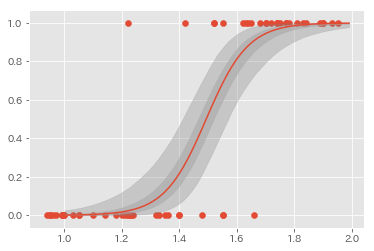

In [20]:
plt.scatter(df["log10 C"], df["death"])
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color="gray")
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.plot(x, f(a * x + b))